# Sample client usage of Filter Pruning Service

#### sample to set up service server
see https://github.com/vuiseng9/nncf/blob/paas/paas/host_paas_image_classification.sh
    

In [50]:
import os, time, random, torch, sys, requests, json
import numpy as np, pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
host_url = 'http://csr-dgx1-03.jf.intel.com:5002/'

In [102]:
url_ready = host_url + 'ready_state'
url_graphviz = host_url + 'get_model_graph_viz'
url_optype = host_url + 'get_node2optype_map'
url_connectivity = host_url + 'get_connectivity_map'
url_prunable = host_url + 'get_prunable_attr'
url_graph_features = host_url + 'layer_graph_data'
url_eval_req = host_url + 'sample_eval_req'
url_evaluate = host_url + 'evaluate'

#### Check if service is ready

In [53]:
requests.get(url=url_ready).json()

{'config': '/home/vchua/ote-fd/nncf/paas/cfg/vgg11_filter_paas.json',
 'method': 'ready_state',
 'msg': 'Environment imgnet initialized',
 'rc': 0}

#### Graph visualization

Note: you can download through browser with this url http://csr-dgx1-03.jf.intel.com:5002/get_model_graph_viz


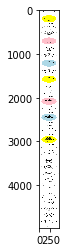

In [54]:
# download a copy of model graph with colorized prunable nodes
print('Note: you can download through browser with this url {}'.format(url_graphviz))

imgpth = 'model_graph.png'
r = requests.get(url_graphviz, allow_redirects=True)
with open(imgpth, 'wb') as fh:
    fh.write(r.content)

plt.imshow(plt.imread(imgpth))

### Graph node to operation type

In [55]:
node_type=requests.get(url=url_optype).json()
node_type

{'0 /nncf_model_input': 'nncf_model_input',
 '1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d': 'conv2d',
 '10 VGG/Sequential[features]/ReLU[9]/RELU': 'RELU',
 '11 VGG/Sequential[features]/MaxPool2d[10]/max_pool2d': 'max_pool2d',
 '12 VGG/Sequential[features]/NNCFConv2d[11]/conv2d': 'conv2d',
 '13 VGG/Sequential[features]/ReLU[12]/RELU': 'RELU',
 '14 VGG/Sequential[features]/NNCFConv2d[13]/conv2d': 'conv2d',
 '15 VGG/Sequential[features]/ReLU[14]/RELU': 'RELU',
 '16 VGG/Sequential[features]/MaxPool2d[15]/max_pool2d': 'max_pool2d',
 '17 VGG/Sequential[features]/NNCFConv2d[16]/conv2d': 'conv2d',
 '18 VGG/Sequential[features]/ReLU[17]/RELU': 'RELU',
 '19 VGG/Sequential[features]/NNCFConv2d[18]/conv2d': 'conv2d',
 '2 VGG/Sequential[features]/ReLU[1]/RELU': 'RELU',
 '20 VGG/Sequential[features]/ReLU[19]/RELU': 'RELU',
 '21 VGG/Sequential[features]/MaxPool2d[20]/max_pool2d': 'max_pool2d',
 '22 VGG/AdaptiveAvgPool2d[avgpool]/adaptive_avg_pool2d': 'adaptive_avg_pool2d',
 '23 VGG/flatten': 'fla

### Connectivity of nodes

In [56]:
node_conn = requests.get(url=url_connectivity).json()
# key of the dictionary is source node
# value is a list of destination nodes

# nodetype can be looked up via previous mapping

for i, (src_node, dst_nodes) in enumerate(node_conn.items()):
    print("* ({}) {}".format(node_type[src_node], src_node))
    for dst_node in dst_nodes:
        print("\t-> ({}) {}".format(node_type[dst_node], dst_node))
    print("")
    if i>=5:
        break

* (nncf_model_input) 0 /nncf_model_input
	-> (conv2d) 1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d

* (conv2d) 1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d
	-> (RELU) 2 VGG/Sequential[features]/ReLU[1]/RELU

* (RELU) 10 VGG/Sequential[features]/ReLU[9]/RELU
	-> (max_pool2d) 11 VGG/Sequential[features]/MaxPool2d[10]/max_pool2d

* (max_pool2d) 11 VGG/Sequential[features]/MaxPool2d[10]/max_pool2d
	-> (conv2d) 12 VGG/Sequential[features]/NNCFConv2d[11]/conv2d

* (conv2d) 12 VGG/Sequential[features]/NNCFConv2d[11]/conv2d
	-> (RELU) 13 VGG/Sequential[features]/ReLU[12]/RELU

* (RELU) 13 VGG/Sequential[features]/ReLU[12]/RELU
	-> (conv2d) 14 VGG/Sequential[features]/NNCFConv2d[13]/conv2d



### Features of prunable nodes

In [57]:
prunable_attr = requests.get(url=url_prunable).json()

In [58]:
prunable_df = pd.DataFrame.from_dict(prunable_attr)

In [59]:
prunable_df.head()

,cin,cluster_id,cout,depthwise,ifm,kernel,module_scope,node_id,node_name,ofm,param,stride
0,3,0,64,0,50176,3,VGG/Sequential[features]/NNCFConv2d[0],1,1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d,50176,1728,1
1,64,1,128,0,12544,3,VGG/Sequential[features]/NNCFConv2d[3],4,4 VGG/Sequential[features]/NNCFConv2d[3]/conv2d,12544,73728,1
2,128,2,256,0,3136,3,VGG/Sequential[features]/NNCFConv2d[6],7,7 VGG/Sequential[features]/NNCFConv2d[6]/conv2d,3136,294912,1
3,256,3,256,0,3136,3,VGG/Sequential[features]/NNCFConv2d[8],9,9 VGG/Sequential[features]/NNCFConv2d[8]/conv2d,3136,589824,1
4,256,4,512,0,784,3,VGG/Sequential[features]/NNCFConv2d[11],12,12 VGG/Sequential[features]/NNCFConv2d[11]/conv2d,784,1179648,1


Nodes grouped as a cluster can be found in this table by cluster id. ```node_name``` can be used to looked up optype and connectivity map.

In [60]:
node2cluster_id = prunable_df[['node_name', 'cluster_id']].set_index('node_name').to_dict()

In [61]:
node2cluster_id['cluster_id']

{'1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d': 0,
 '4 VGG/Sequential[features]/NNCFConv2d[3]/conv2d': 1,
 '7 VGG/Sequential[features]/NNCFConv2d[6]/conv2d': 2,
 '9 VGG/Sequential[features]/NNCFConv2d[8]/conv2d': 3,
 '12 VGG/Sequential[features]/NNCFConv2d[11]/conv2d': 4,
 '14 VGG/Sequential[features]/NNCFConv2d[13]/conv2d': 5,
 '17 VGG/Sequential[features]/NNCFConv2d[16]/conv2d': 6}

### Features per node

In [62]:
from sklearn.preprocessing import OneHotEncoder

from natsort import natsorted

In [63]:
optype_encoder = OneHotEncoder()
cluster_id_encoder = OneHotEncoder()

In [64]:
one_hot_encoded_cluster_id = cluster_id_encoder.fit_transform(np.array(list(node2cluster_id['cluster_id'].values())).reshape(-1,1)).toarray()
one_hot_encoded_cluster_id_map = dict(zip(node2cluster_id['cluster_id'].keys(), one_hot_encoded_cluster_id))
cluster_id_df = pd.Series(data=one_hot_encoded_cluster_id_map.values(), index=one_hot_encoded_cluster_id_map.keys(), name="cluster_id").to_frame()

In [65]:
cluster_id_encoder.categories_

[array([0, 1, 2, 3, 4, 5, 6])]

In [66]:
cluster_id_df.head(3)

,cluster_id
1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4 VGG/Sequential[features]/NNCFConv2d[3]/conv2d,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7 VGG/Sequential[features]/NNCFConv2d[6]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [67]:
one_hot_encoded_optype = optype_encoder.fit_transform(np.array(list(node_type.values())).reshape(-1,1)).toarray()
one_hot_encoded_optype_map = dict(zip(node_type.keys(), one_hot_encoded_optype))
optype_df = pd.Series(data=one_hot_encoded_optype_map.values(), index=one_hot_encoded_optype_map.keys(), name="optype").to_frame()
optype_df = optype_df.reindex(natsorted(optype_df.index))

In [68]:
optype_encoder.categories_

[array(['RELU', 'adaptive_avg_pool2d', 'conv2d', 'dropout', 'flatten',
        'linear', 'max_pool2d', 'nncf_model_input', 'nncf_model_output'],
       dtype='<U19')]

In [69]:
optype_df.head(3)

,optype
0 /nncf_model_input,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2 VGG/Sequential[features]/ReLU[1]/RELU,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [70]:
prunable_features = prunable_df.drop(columns=['module_scope', 'cluster_id']).set_index('node_name')

In [71]:
prunable_features.head(3)

,cin,cout,depthwise,ifm,kernel,node_id,ofm,param,stride
node_name,,,,,,,,,
1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d,3,64,0,50176,3,1,50176,1728,1
4 VGG/Sequential[features]/NNCFConv2d[3]/conv2d,64,128,0,12544,3,4,12544,73728,1
7 VGG/Sequential[features]/NNCFConv2d[6]/conv2d,128,256,0,3136,3,7,3136,294912,1


In [72]:
features_per_node = pd.concat([optype_df, prunable_features], axis=1).fillna(0)

In [73]:
features_per_node = pd.concat([features_per_node, cluster_id_df], axis=1)

In [74]:
np.zeros_like(one_hot_encoded_cluster_id[0])

array([0., 0., 0., 0., 0., 0., 0.])

In [75]:
features_per_node['cluster_id'] = \
    [np.zeros_like(one_hot_encoded_cluster_id[0]) if isinstance(val, float) else val for val in features_per_node['cluster_id'].to_list()]

In [76]:
features_per_node

,optype,cin,cout,depthwise,ifm,kernel,node_id,ofm,param,stride,cluster_id
0 /nncf_model_input,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1 VGG/Sequential[features]/NNCFConv2d[0]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3.0,64.0,0.0,50176.0,3.0,1.0,50176.0,1728.0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2 VGG/Sequential[features]/ReLU[1]/RELU,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3 VGG/Sequential[features]/MaxPool2d[2]/max_pool2d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4 VGG/Sequential[features]/NNCFConv2d[3]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",64.0,128.0,0.0,12544.0,3.0,4.0,12544.0,73728.0,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5 VGG/Sequential[features]/ReLU[4]/RELU,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6 VGG/Sequential[features]/MaxPool2d[5]/max_pool2d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7 VGG/Sequential[features]/NNCFConv2d[6]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",128.0,256.0,0.0,3136.0,3.0,7.0,3136.0,294912.0,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8 VGG/Sequential[features]/ReLU[7]/RELU,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9 VGG/Sequential[features]/NNCFConv2d[8]/conv2d,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",256.0,256.0,0.0,3136.0,3.0,9.0,3136.0,589824.0,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


#### Features per Node API

In [77]:
graph_features = requests.get(url=url_graph_features).json()

In [78]:
graph_feature_df = pd.DataFrame.from_dict(graph_features)

In [79]:
graph_features.keys()

dict_keys(['action_space', 'edges', 'node_features', 'rc'])

#### Sample evaluation configuration

In [80]:
eval_cfg = requests.get(url=url_eval_req).json()
# key is cluster id
# value is the pruning rate of a cluster
# replace value between 0 - 1
eval_cfg

{'0': 0.0, '1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0}

#### Evaluation with random groupwise pruning 

In [81]:
eval_cfg = {k: np.around(np.random.random(), 3) for k, v in eval_cfg.items()}

In [82]:
eval_cfg

{'0': 0.958,
 '1': 0.315,
 '2': 0.721,
 '3': 0.919,
 '4': 0.226,
 '5': 0.564,
 '6': 0.442}

In [83]:
req = requests.post(url_evaluate, json = eval_cfg)

In [84]:
eval_results = req.json()

In [85]:
for k in eval_results.keys():
    print(k)

cached_eval
meta_data
msg
processing_time
rc


## What is new?

### Two type of evaluation (synonymous to ML validation and test)

In [98]:
# both /evaluate and /test have exact interface
host_url = 'http://csr-dgx1-03.jf.intel.com:5005/'
url_evaluate = host_url + 'evaluate'
url_test = host_url + 'test'

In [92]:
eval_cfg = requests.get(url=url_eval_req).json()
eval_cfg

{'0': 0.0, '1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0}

##### A new metadata (key:eval_type) to indicate the type of evaluation

In [94]:
req = requests.post(url_evaluate, json = eval_cfg)
eval_results = req.json()
print(eval_results['meta_data']['eval_type'], eval_results['meta_data']['task_metric'])

evaluate {'top1': 69.03044871794872, 'top5': 86.43830128205128}


In [95]:
req = requests.post(url_test, json = eval_cfg)
eval_results = req.json()
print(eval_results['meta_data']['eval_type'], eval_results['meta_data']['task_metric'])

test {'top1': 69.0625, 'top5': 88.64983974358974}


##### Sample output of Face Detection evaluate and test

In [103]:
url_eval_req = host_url + 'sample_eval_req'
url_evaluate = host_url + 'evaluate'
eval_cfg = requests.get(url=url_eval_req).json()
req = requests.post(url_evaluate, json = eval_cfg)
eval_results = req.json()
print(eval_results['meta_data']['eval_type'], eval_results['meta_data']['task_metric'])

evaluate {'loss': 3.104176954789595, 'loss_bbox': 0.9102993137908705, 'loss_cls': 2.1938776355801206}


In [104]:
url_eval_req = host_url + 'sample_eval_req'
url_test = host_url + 'test'
eval_cfg = requests.get(url=url_eval_req).json()
req = requests.post(url_test, json = eval_cfg)
eval_results = req.json()
print(eval_results['meta_data']['eval_type'], eval_results['meta_data']['task_metric'])

test {'bbox_mAP': 0.16, 'bbox_mAP_50': 0.329, 'bbox_mAP_75': 0.14, 'bbox_mAP_copypaste': '0.160 0.329 0.140 0.045 0.395 0.624', 'bbox_mAP_l': 0.624, 'bbox_mAP_m': 0.395, 'bbox_mAP_s': 0.045}


### Basic fine-tuning config will be returned as well

*** Please save this on NEMO end

In [105]:
eval_results['meta_data']['ft_cfg']

{'algorithm': 'filter_pruning',
 'compression_lr_multiplier': None,
 'eval_cache': True,
 'ignored_scopes': ['SingleStageDetector/SSDHead[bbox_head]/ModuleList[cls_convs]/Sequential[0]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[cls_convs]/Sequential[0]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[reg_convs]/Sequential[0]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[reg_convs]/Sequential[0]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[reg_convs]/Sequential[1]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[reg_convs]/Sequential[1]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[cls_convs]/Sequential[1]/NNCFConv2d[0]',
  'SingleStageDetector/SSDHead[bbox_head]/ModuleList[cls_convs]/Sequential[1]/NNCFConv2d[0]'],
 'log_dir': '/tmp/paas-facedet-log/face-detection-0200-2021-07-01__23-23-20',
 'params': {'groupwise_pruning_cfg': {'0': 0.0,
   '1': 0.0,
 